# CHALLENGE DATA ENEDIS
Challenge context

About Enedis

ENEDIS is the main distribution system operator in France (95% of continental France, 36 million customers).

The electricity market requires that production and consumption be assigned to an upstream-downstream balance operator, each electricity provider having at least one. These balance operators guarantee that supply and demand are balanced every half-hour 24/7.

In order to assign energy, Enedis computes the electricity consumption balance every week for each balance operator. Part of the balancing computation involves some consumption or production modelling for several groups of customers (aka profiles). Since July 1st 2018, we started using “dynamic” profiles in this process, computed with measured energy. These dynamic profiles bring additional precision but can only be calculated ex-post.

Being able to forecast these values is very important since:

    They would bring robustness to our process.

    Energy planning is of utmost importance to balance operators, who have to guarantee energy supply beforehand and are held responsible for any unbalance in their portfolio.

Challenge goals

We would like to forecast 7 dynamic profile time-series, modelling the consumption shape of several mass-market customer groups (residential and small businesses with subscribed power up to 36 kVA) thanks to meteorological and calendar data, as well as any other real time dataset potentially correlated with consumption patterns. Those profiles are coefficients (without units) for each half-hour in the dataset.

The dataset size depends on each specific profile (collected from Oct 13th, 2013 onwards for residential profiles and from Nov 1st, 2016 for commercial profiles). This challenge is about forecasting dynamic profiles values from their past values and all the components of Enedis’ Half hourly Electrical Balancing.

The Testing period will be in the past, from July 1st, 2017 to June 30th, 2018.

There are many possible explanatory variables since consumption patterns are linked to consumers’ behavior and economic activity. Weather conditions (cold spell / heat wave) and business holidays will impact energy consumption but some other factors may also contribute to modifying energy consumption. As an example, our RES1 profile is presented there, over a week period:
In green: static series including business holidays. In blue: static series including business holidays and weather. In red: dynamic series computed ex-post.

Presentation of the challenge at the Collège de France

You can find the presentation of the challenge made at the Collège de France here (video in French)
Data description

Edit - 2019/03/22

Please be careful to the temporal alignment: For the same ID, there is a one day delay between data provided in the input files (that are measured or estimated for the date given in Horodate_UTC ) and the values of dynamic Profiles provided in the output files (representing customer behaviour for the date given in horodate). This delay allows to have a challenge closer to our operational needs: we will be able to get the data from the input files of the previous day to forecast the dynamic profiles.

Data in the time series are hour beginning: for example, a value at à 08h00 is the integrated value from 08h00 to 08h30 for the said data.
Training files include data for the period [13/10/2013 - 12/10/2018] excluding the [01/07/2017 - 30/06/2018] period.
Regarding the 3 commercial profiles, data only start on Nov 1st,2016.
Testing files include data for the [01/07/2017 - 30/06/2018] period.
Please note that we use the French date and time notation: dd/mm/YYYY HH:MM in the files.
Time series description for the input files
Weather data:

    Température réalisée lissée (°Celcius) Average recorded temperature (°C)
    Température normale lissée (°Celcius) Average standard temperature (°C)
    Pseudo rayonnement Pseudo radiation (Linear combination of recorded data from 32 official weather stations

Measured data

    Electricity exchange with other networks:
    Injection RTE (W) Average power (during the half hours) injected from RTE (transmission grid) (W)
    Refoulement RTE (W) Average power injected back into the transmission grid (W)

    Soutirage net vers autres GRD (W) Average power injected into local DSO networks (W)

    From Smart meters
    Consommation HTA télérelevée en courbe de charge (W) load curve-measured medium voltage (MV, i.e., 20 000 V in most areas) consumption (W)
    Production décentralisée télérelevée en courbe de charge (W) load curve-measured decentralized production (W)

Modelled Data:

    Pertes modélisées (W) Losses Model based on a second order polynomial, recalibrated every year. (Based on RTE gross injection until July 1st, 2018, and on net RTE injection (Power injected – Power injected back to transmission grid), net Power injected into local independent DSOs and decentralized production since that date.
    Consommation totale profilée (W) Total modelled consumption (W)
    Consommation HTA profilée (W) MV modelled consumption (W)
    Consommation PME-PMI profilée (W) SMEs and SMIs modelled consumption (W)
    Consommation professionnelle profilée (W) Small businesses modelled consumption (W)
    Consommation résidentielle profilée (W) Households modelled consumption (W)
    Production décentralisée profilée (W) Total modelled decentralized production (W)
    Production photovoltaïque profilée (W) Photovoltaic modelled production (W)
    Production autre profilée (W) Other modelled decentralized production (W) Modelling of customer consumption through static profiling until July 1st, 2018. Since then the modelling technique has changed for 7 consumption sub profiles, from static to dynamic modelling based on real measurements.

Sums (from Models and Measurements):

    Consommations totale (W) Total consumption (W)
    Production décentralisée totale (W) Total decentralized production (W)
    Production éolienne totale (W) Total wind production (W)
    Production photovoltaïque totale (W) Total Photovoltaic production (W)
    Consommation HTA totale (W) total MV consumption (W)

Time Series description for the Output Files

    RES1_BASE: Residential customer profile, subscribed power up to 6kVA, with no tariff option
    RES11_BASE: Residential customer profile, subscribed power over 6kVA, with no tariff option
    RES2_HP: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours.
    RES2_HC: Residential customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.
    PRO1_BASE: Commercial customer profile, with no tariff option
    PRO2_HP: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Peak hours
    PRO2_HC: Commercial customer profile, with Peak Hours/Off Peak Hours tariff option, during Off Peak hours.


In [50]:
from dataviz import data_slice,data_timeplot,data_slice_year,data_slice_date
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from matplotlib.dates import (HourLocator, AutoDateLocator, DateFormatter,
                              ConciseDateFormatter, rrulewrapper, RRuleLocator, drange)

In [2]:

X_train=pd.read_csv('training_input_qFI2jug.csv', index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
feature_list=list(X_train.columns[3:])
#X_train['timestamp']=pd.to_datetime(X_train.index)
X_train.index = pd.DatetimeIndex(X_train.index)

liste_dates = X_train.index.tolist()
for dt in liste_dates :
    X_train.at[dt, 'sort'] = dt.strftime('%m%d%H%S')

X_train['sort'].astype(int)

df_month = X_train.sort_values(by='sort', ascending=True)
df_month.head(20)
df_month = df_month.interpolate(str="linear", axis=0).ffill().bfill()
df = df_month.sort_values(by='IDS', ascending=True)

X_train.drop('sort', axis=1)

X_train['Pseudo rayonnement'] = df['Pseudo rayonnement']
X_train['timestamp']=pd.to_datetime(X_train.index)




In [3]:
X_test=pd.read_csv('testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [4]:
y_train=pd.read_csv('training_output_uamzSZW.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

In [5]:
X_train.describe()

IDS          Mois  Injection RTE (W)  Refoulement RTE (W)  \
count  70128.000000  70128.000000       7.012800e+04         7.012800e+04   
mean   36311.645791      6.523728       3.903467e+10         1.016443e+09   
std    22613.359627      3.448722       9.854703e+09         8.505473e+08   
min        1.000000      1.000000       1.951452e+10         3.570200e+07   
25%    17532.750000      4.000000       3.175362e+10         4.212288e+08   
50%    35064.500000      7.000000       3.736196e+10         7.282295e+08   
75%    52596.250000     10.000000       4.568327e+10         1.330693e+09   
max    87648.000000     12.000000       7.428889e+10         6.377620e+09   

       Pertes modélisées (W)  Consommations totale (W)  \
count           7.012800e+04              7.012800e+04   
mean            2.710008e+09              3.936041e+10   
std             8.737662e+08              9.679018e+09   
min             1.202823e+09              1.974821e+10   
25%             2.075660e+09              3.207500e+10   
50%             2.473475e+09              3.807145e+10   
75%             3.270841e+09              4.621237e+10   
max             6.350213e+09              7.228106e+10   

       Consommation HTA télérelevée à courbe de charge (W)  \
count                                       7.012800e+04     
mean                                        1.136792e+10     
std                                         2.548024e+09     
min                                         6.504355e+09     
25%                                         9.092981e+09     
50%                                         1.103755e+10     
75%                                         1.378292e+10     
max                                         1.681509e+10     

       Consommation totale profilée (W)  Consommation HTA profilée (W)  \
count                      7.012800e+04                   7.012800e+04   
mean                       2.799248e+10                   1.521529e+09   
std                        8.665369e+09                   4.554593e+08   
min                        1.298053e+10                   6.333796e+08   
25%                        2.150951e+10                   1.176633e+09   
50%                        2.550163e+10                   1.499332e+09   
75%                        3.473953e+10                   1.849438e+09   
max                        5.774080e+10                   2.942461e+09   

       Consommation PME-PMI profilée (W)  ...  \
count                       7.012800e+04  ...   
mean                        4.956707e+09  ...   
std                         1.589747e+09  ...   
min                         2.248863e+09  ...   
25%                         3.649392e+09  ...   
50%                         4.624335e+09  ...   
75%                         6.119550e+09  ...   
max                         1.105398e+10  ...   

       Production décentralisée profilée (W)  \
count                           7.012800e+04   
mean                            3.878029e+08   
std                             5.361542e+08   
min                             6.896886e+06   
25%                             2.054498e+07   
50%                             3.801786e+07   
75%                             6.738169e+08   
max                             2.456034e+09   

       Production photovoltaïque profilée (W)  Production autre profilée (W)  \
count                            7.012800e+04                   7.012800e+04   
mean                             3.674776e+08                   1.772841e+06   
std                              5.365895e+08                   2.002542e+06   
min                              0.000000e+00                   6.944200e+04   
25%                              0.000000e+00                   9.941500e+04   
50%                              1.629145e+07                   1.656505e+06   
75%                              6.511670e+08                   2.649071e+06   
max                              2.441262e+09             

In [6]:
X_train.describe().to_csv("C:/Users/fred_/_formation_chef_de_projet_data_ingeneering/challenge-data-ens/df.txt")

# raw feature corellation

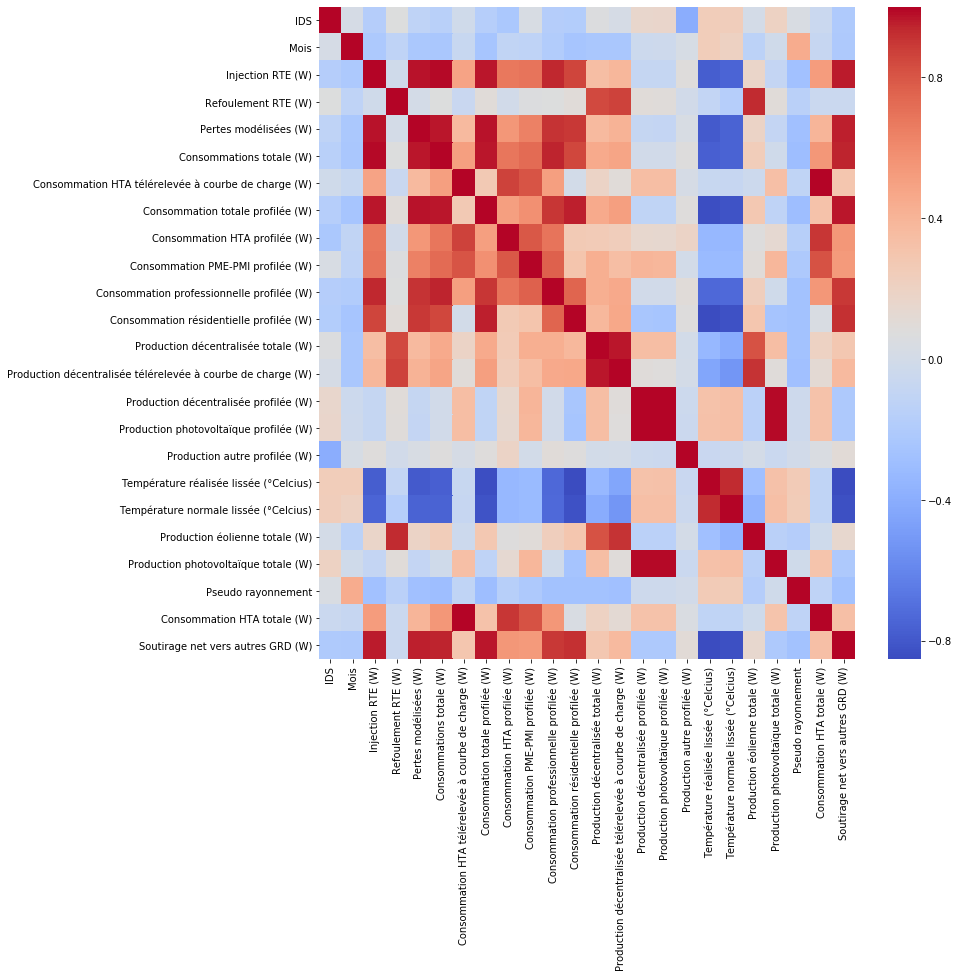

In [7]:

corr=X_train.corr()
fig,ax=plt.subplots(figsize=(12,12))
sns.heatmap(corr,ax=ax,cmap='coolwarm')
plt.show()

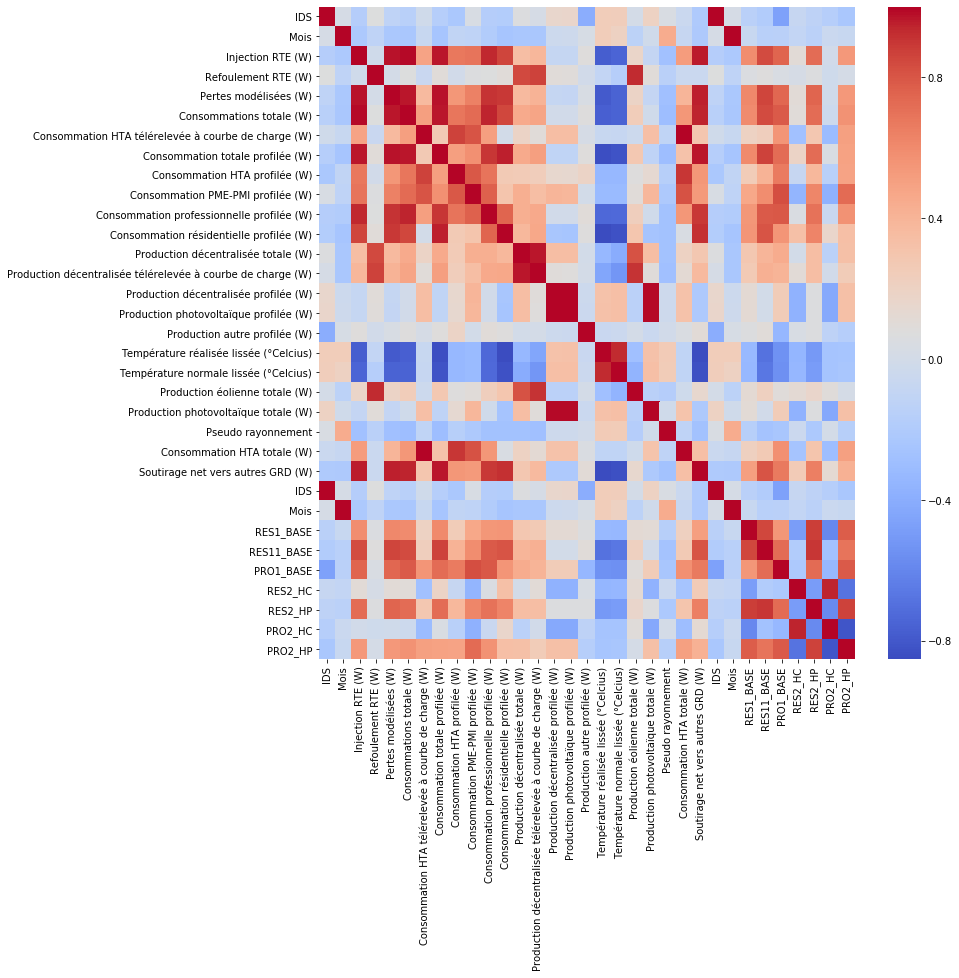

In [8]:
df=pd.concat([X_train,y_train],axis=1)
fig,ax=plt.subplots(figsize=(12,12))
sns.heatmap(df.corr(),ax=ax,cmap='coolwarm')
plt.show()

# Analyses des séries temporelles

# Snapchot of training input over 1 day period

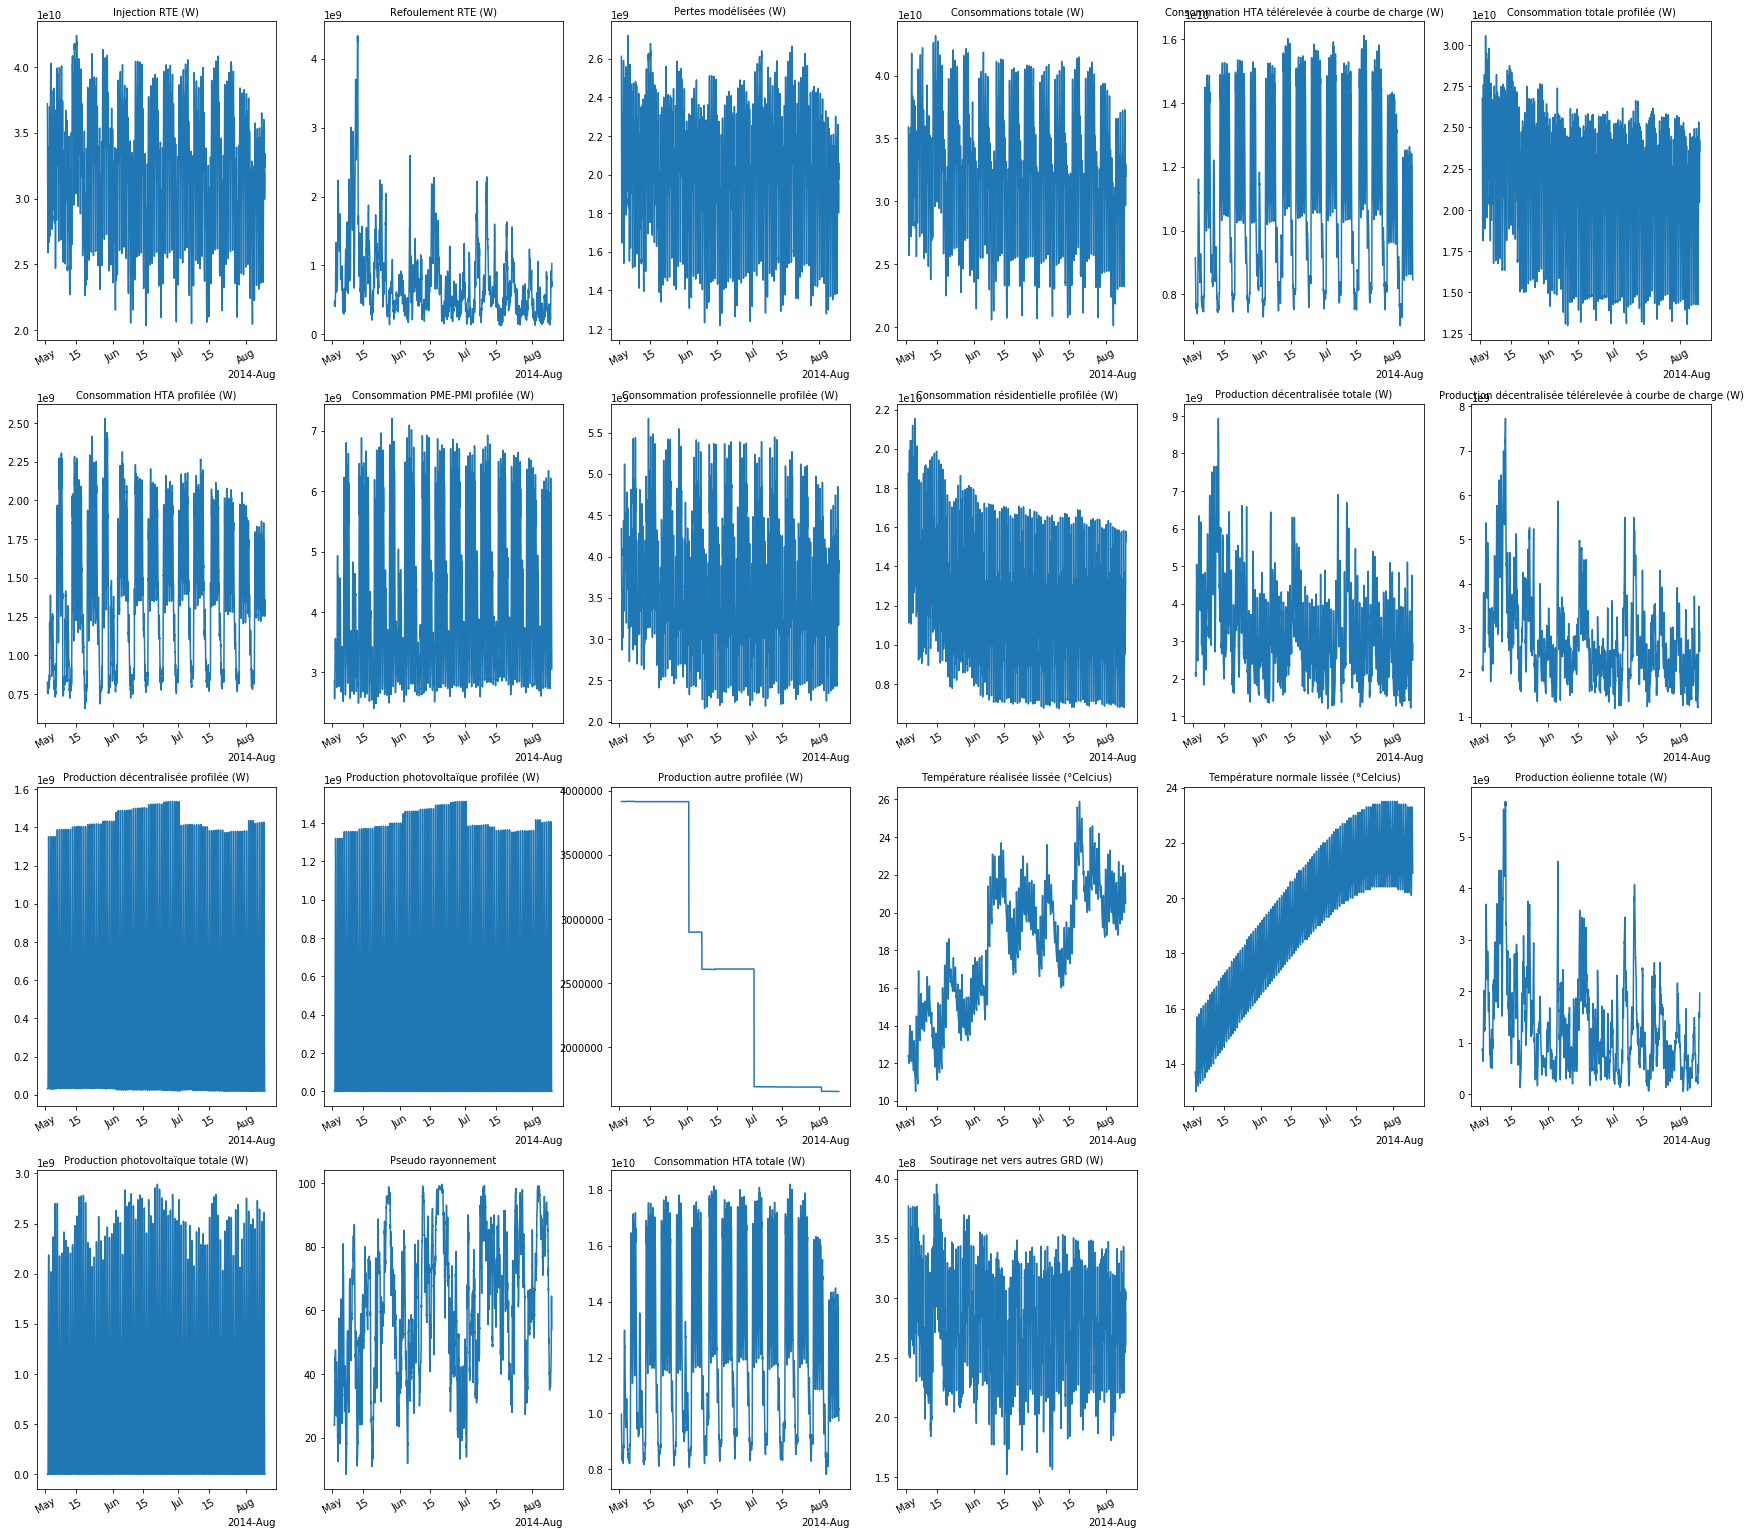

In [9]:
from dataviz import data_slice,data_timeplot

df_slice=data_slice(X_train,200,100,feature_list)
data_timeplot(df_slice,6)


# Visualisation profile RES1_BASE

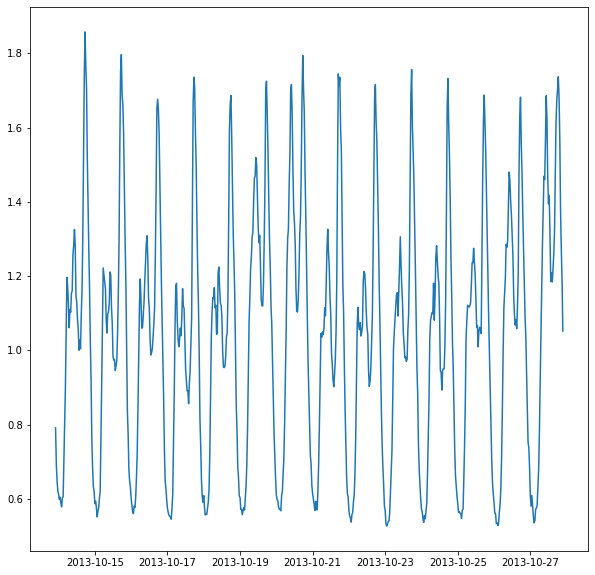

In [10]:
y_slice=data_slice(y_train,0,14,columns=['RES1_BASE'])
plt.figure(figsize=(10,10))
plt.plot(y_slice)

# Snapchot of testing input over 1 day period

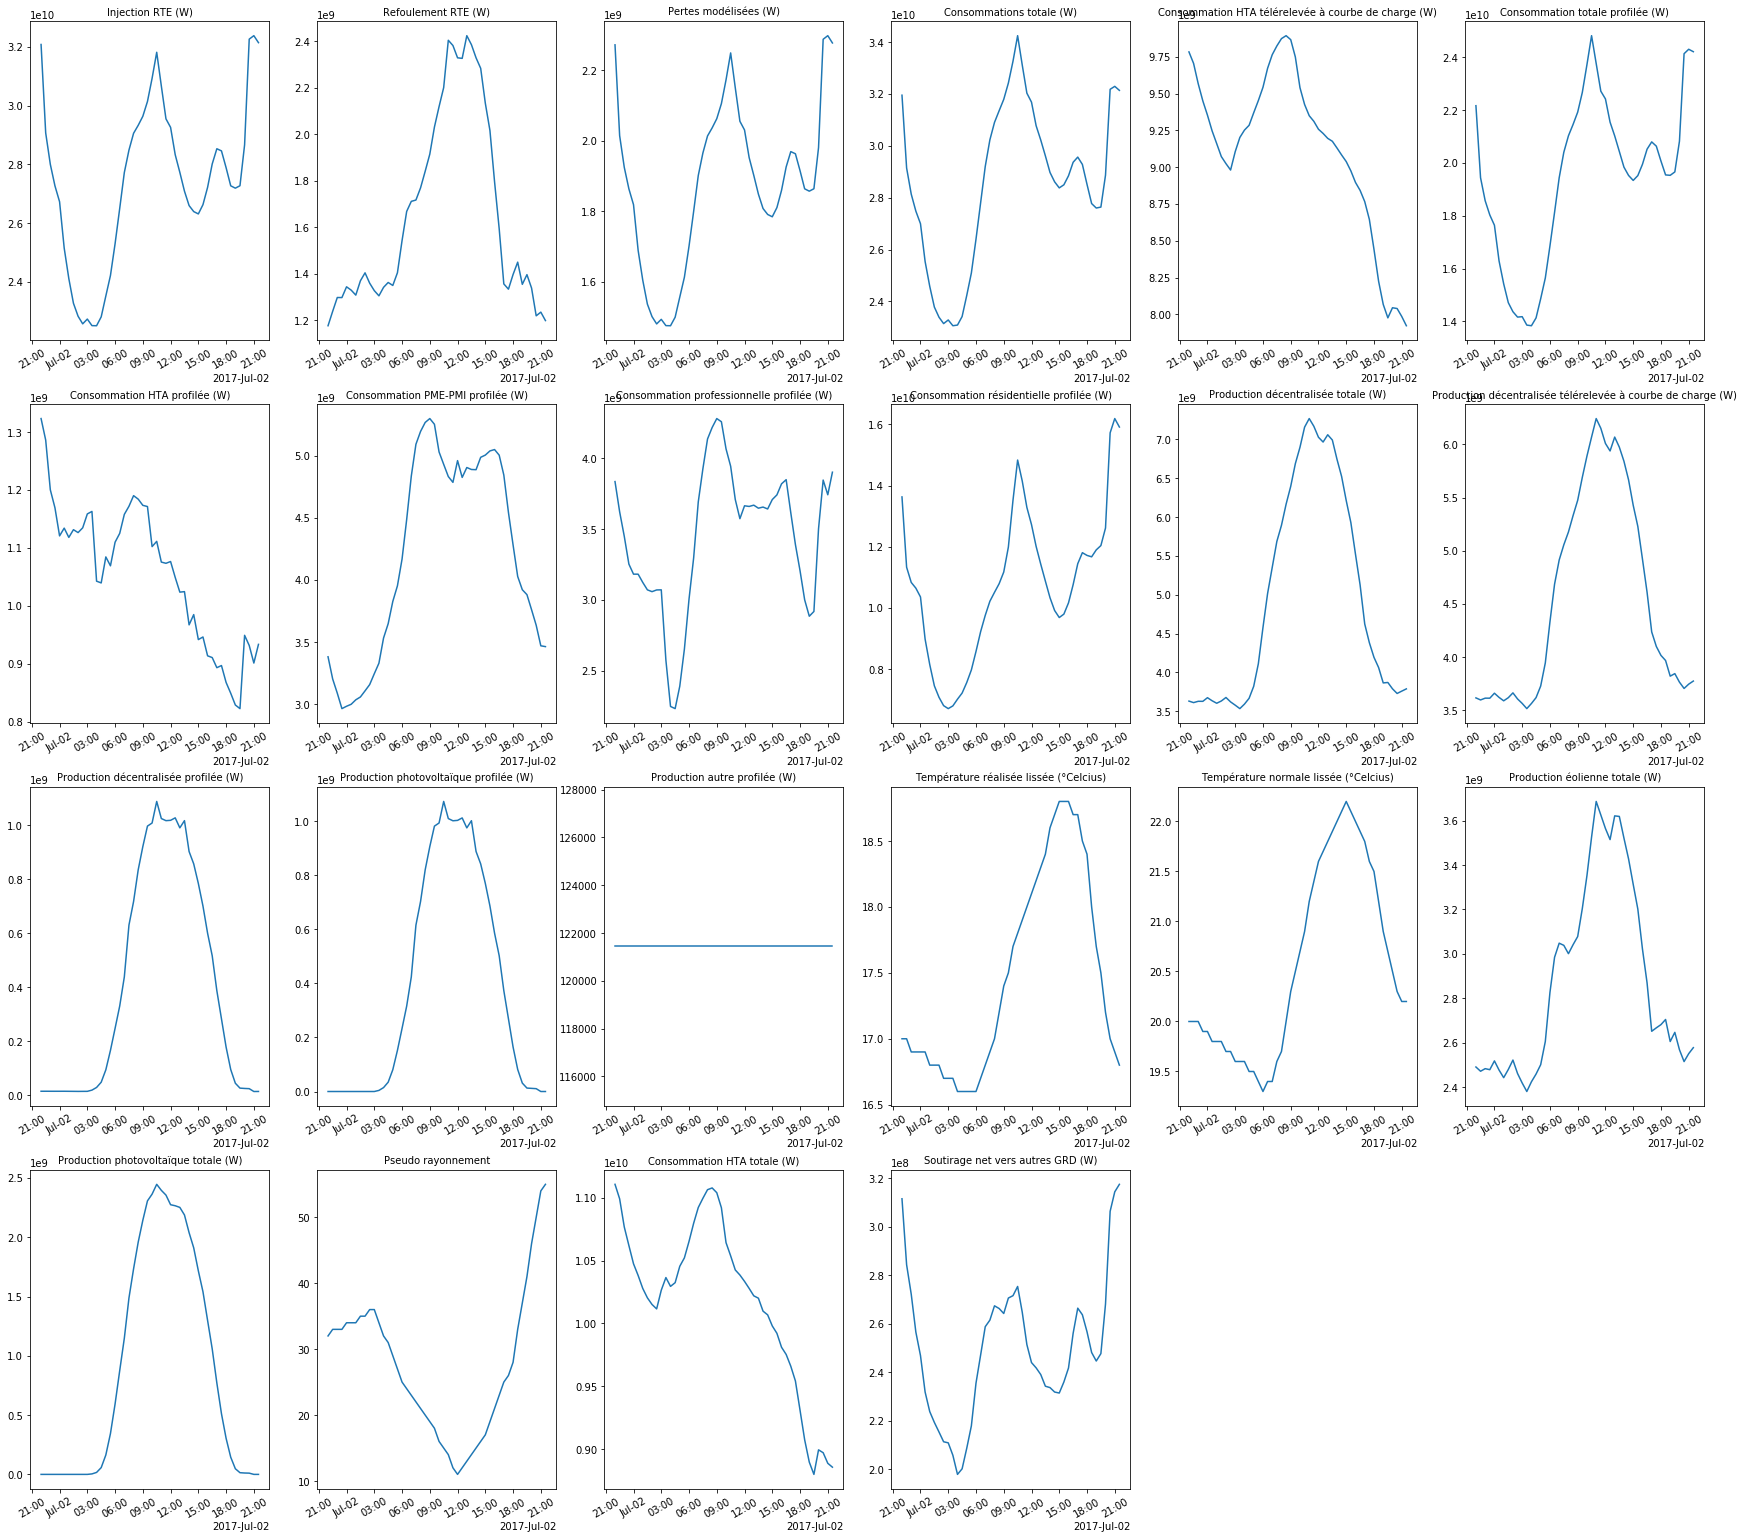

In [11]:

from dataviz import data_slice,data_timeplot

df_slice=data_slice(X_test,0,1,feature_list)
data_timeplot(df_slice,6)

# visualisation of training input after daily and wekly resampling

In [12]:
X_daily=X_train.resample('D').sum()
X_weekly=X_train.resample('W').sum()

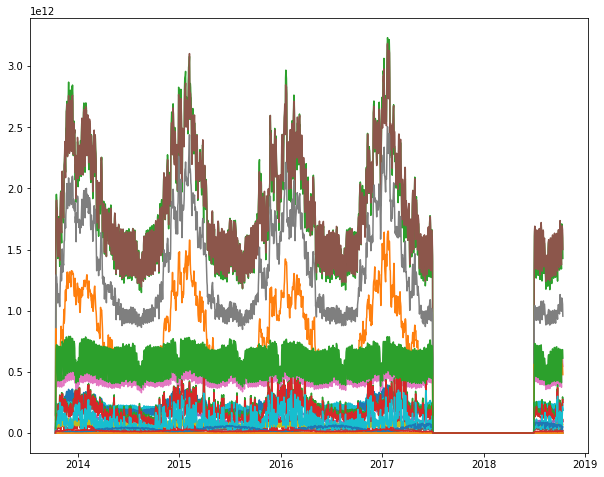

In [13]:
plt.figure(figsize=(10,8))
plt.plot(X_daily)
plt.show()

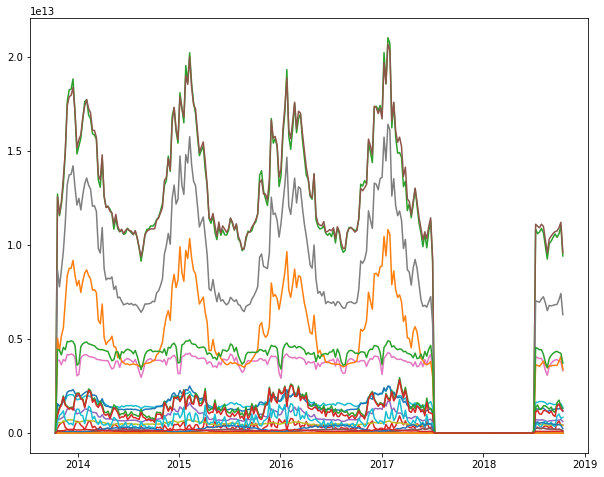

In [14]:
plt.figure(figsize=(10,8))
plt.plot(X_weekly)
plt.show()

## Computation of pivot-table 

this will be usefull for the profile clustering

Creation of two new columns hour (hour of the day) and day (day of the year)
Computation of the pivot-table for the feature 'Consommation professionnelle profilée (W)'
The new dataframe reflects the distribution of daily profile over the DataFrame timespan
The example shows distribution over 2014 year

In [55]:
y_train['hour']=y_train['timestamp'].dt.time
y_train['day']=y_train['timestamp'].dt.dayofyear
temp=data_slice_date(y_train,date(2013,10,15),date(2017,6,30))
temp_all_days=temp.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)
temp_all_days.head()

RES1_BASE                                                    \
day            1         2         3         4         5         6     
hour                                                                   
00:00:00  1.046657  0.820955  0.832823  0.816627  0.806087  0.798441   
00:30:00  1.015541  0.800246  0.800034  0.791272  0.771944  0.764722   
01:00:00  0.978556  0.777121  0.761908  0.763819  0.738278  0.739977   
01:30:00  0.918925  0.761961  0.726835  0.742898  0.730101  0.721020   
02:00:00  0.902490  0.743349  0.717357  0.727074  0.720251  0.716772   

                                                  ...                      \
day            7         8         9         10   ...       357       358   
hour                                              ...                       
00:00:00  0.807202  0.801733  0.761297  0.767005  ...  0.732517  0.749668   
00:30:00  0.777307  0.765678  0.730764  0.731933  ...  0.705356  0.723224   
01:00:00  0.741384  0.734163  0.710825  0.705728  ...  0.677903  0.687435   
01:30:00  0.737322  0.714755  0.690435  0.688656  ...  0.663141  0.669540   
02:00:00  0.724791  0.712206  0.678806  0.675487  ...  0.654964  0.659345   

                                                                      \
day            359       360       361       362       363       364   
hour                                                                   
00:00:00  0.960077  0.827274  0.774758  0.797299  0.842593  0.840337   
00:30:00  0.897791  0.799821  0.749376  0.769660  0.819787  0.802715   
01:00:00  0.828336  0.757368  0.711993  0.734800  0.777254  0.776829   
01:30:00  0.762386  0.720251  0.694444  0.710586  0.744783  0.751049   
02:00:00  0.731322  0.704002  0.675806  0.704825  0.722985  0.747916   

                              
day            365       366  
hour                          
00:00:00  0.873763  0.950811  
00:30:00  0.833752  0.928616  
01:00:00  0.788325  0.888897  
01:30:00  0.769766  0.872117  
02:00:00  0.766979  0.840894  

[5 rows x 366 columns]

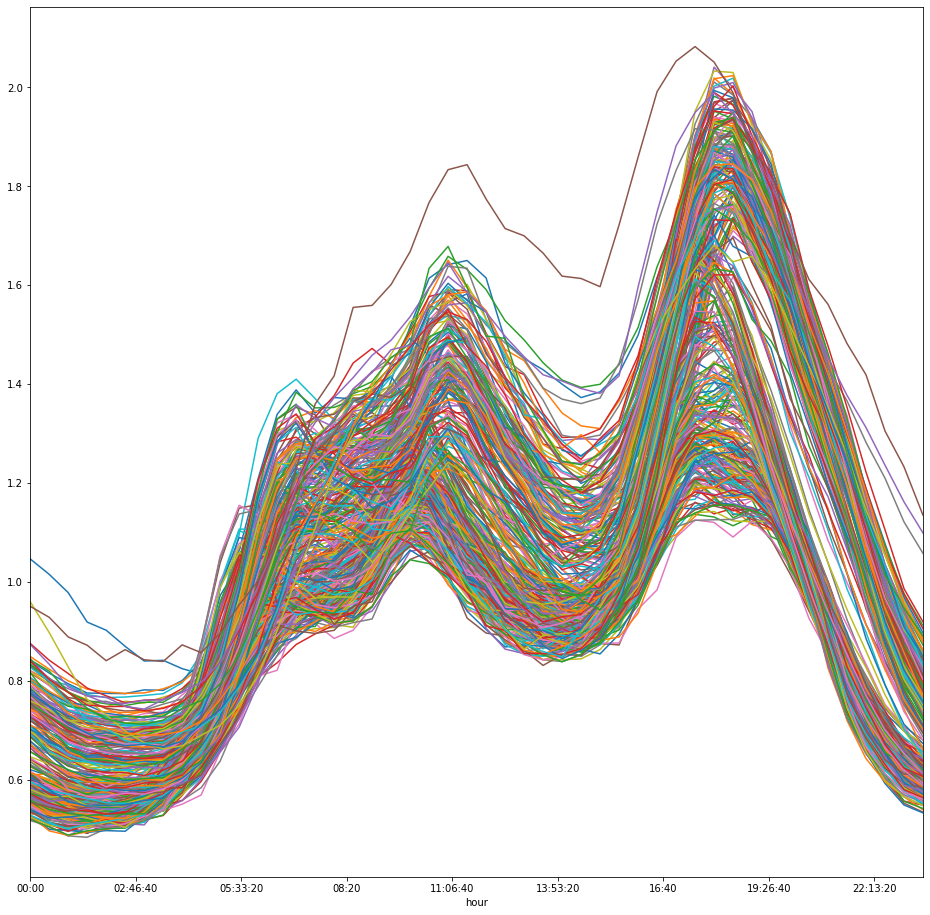

In [17]:
temp_all_days.plot(figsize=(16,16),legend=False)

In [18]:
from scipy.cluster.hierarchy import dendrogram,linkage
z=linkage(temp_all_days,'ward')

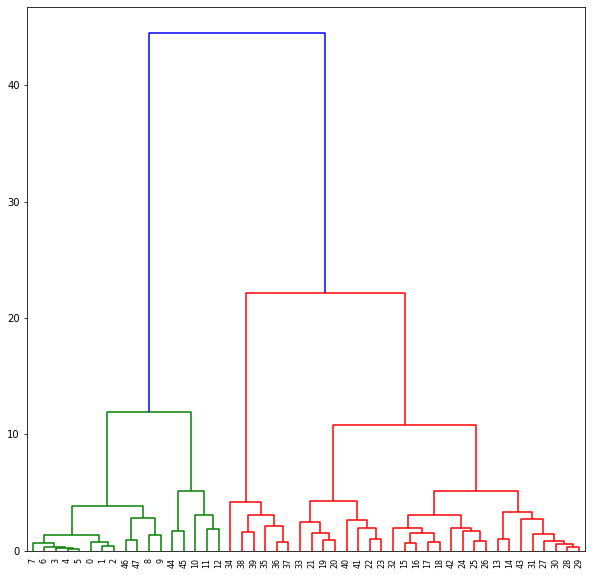

In [19]:
plt.figure(figsize=(10,10))
dendrogram(z,leaf_rotation=90,leaf_font_size=8)
plt.show()

In [20]:
from sklearn.cluster import AgglomerativeClustering



## Computation of pivot-table after splitting between business and non business days

Show the profiles distribution after split

In [21]:
from jours import holydays, summer_winter_time

calendar = holydays()

calendar.Dataframe(temp)

calendar.split()

temp_business_days=calendar.business_days()
temp_public_holiday=calendar.public_holiday()

pivot table analysis to extract daily profiles

In [22]:


temp_business_days=temp_business_days.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)
temp_public_holiday=temp_public_holiday.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)


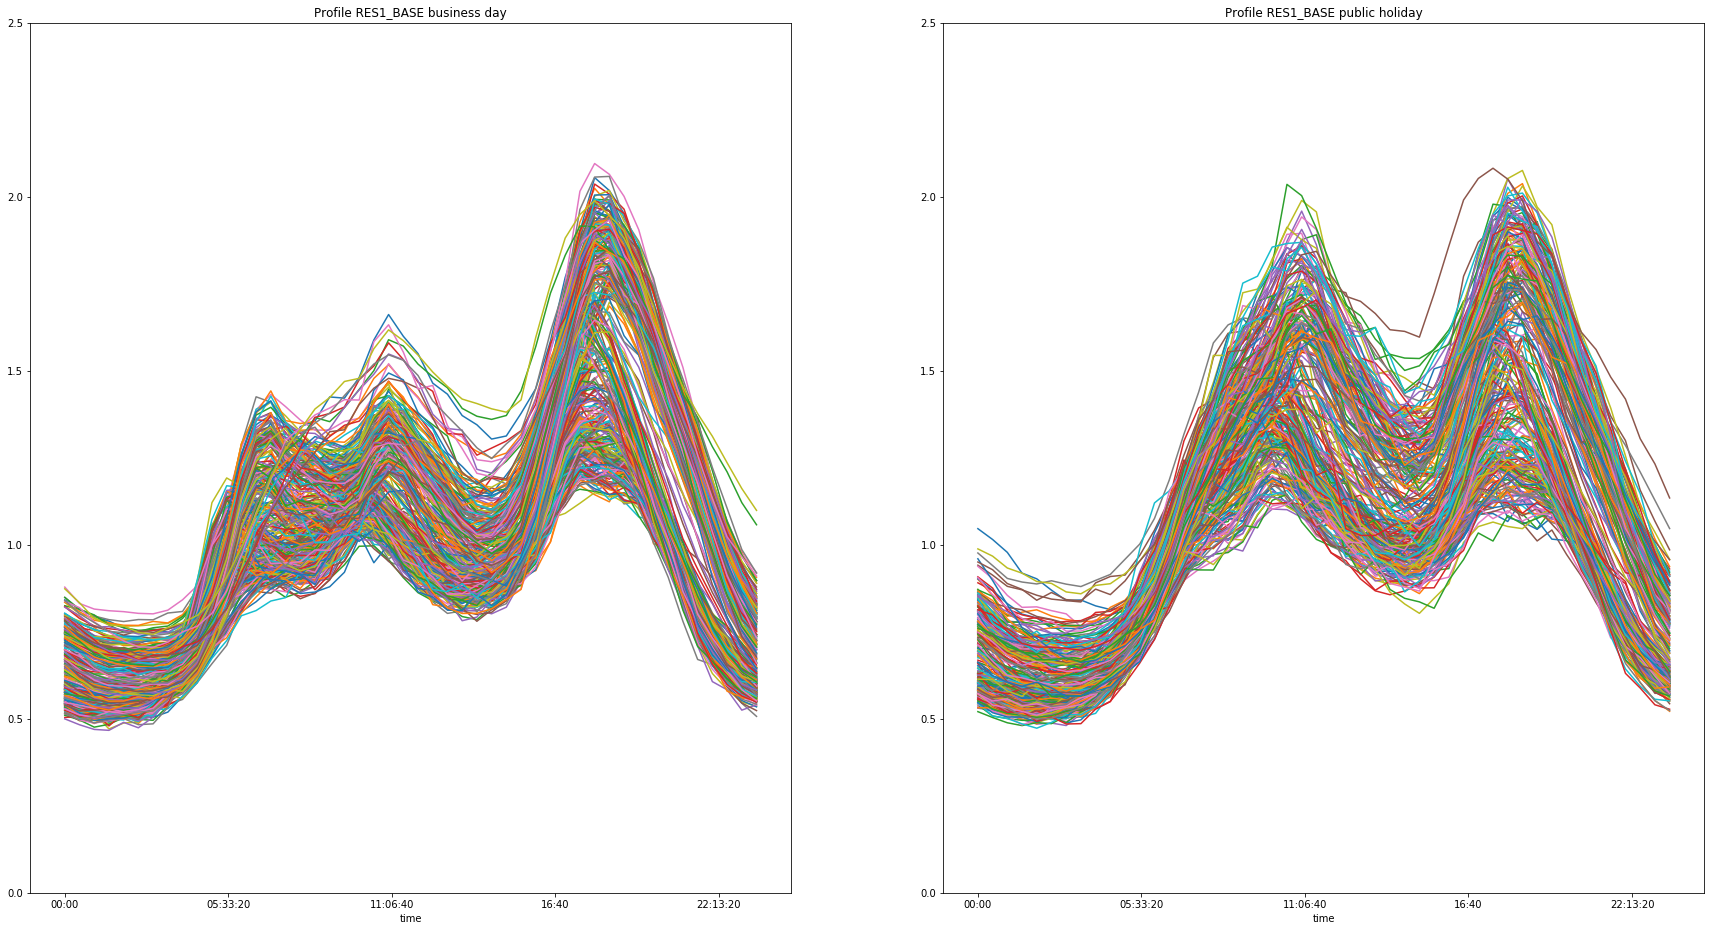

In [23]:
plt.figure(figsize=(30,16))
plt.subplot(121)
plt.ylim((0,2.5))
plt.plot(temp_business_days.index,temp_business_days)
plt.title('Profile RES1_BASE business day')
plt.subplot(122)
plt.ylim((0,2.5))
plt.title('Profile RES1_BASE public holiday')
plt.plot(temp_public_holiday.index,temp_public_holiday)
plt.show()

In [31]:
changeover = summer_winter_time(temp)
changeover.split()
summer_time = changeover.summer_time()
winter_time = changeover.winter_time()

calendar.Dataframe(summer_time)
temp_summer_business_days=calendar.business_days()
temp_summer_public_holiday=calendar.public_holiday()
calendar.Dataframe(winter_time)
temp_winter_business_days=calendar.business_days()
temp_winter_public_holiday=calendar.public_holiday()

temp_summer_business_days=temp_summer_business_days.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)
temp_summer_public_holiday=temp_summer_public_holiday.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)
temp_winter_business_days=temp_winter_business_days.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)
temp_winter_public_holiday=temp_winter_public_holiday.pivot_table(index=['hour'],columns=['day'],values=['RES1_BASE'],fill_value=0)

(array([-20000.,      0.,  20000.,  40000.,  60000.,  80000., 100000.]), <a list of 7 Text xticklabel objects>)


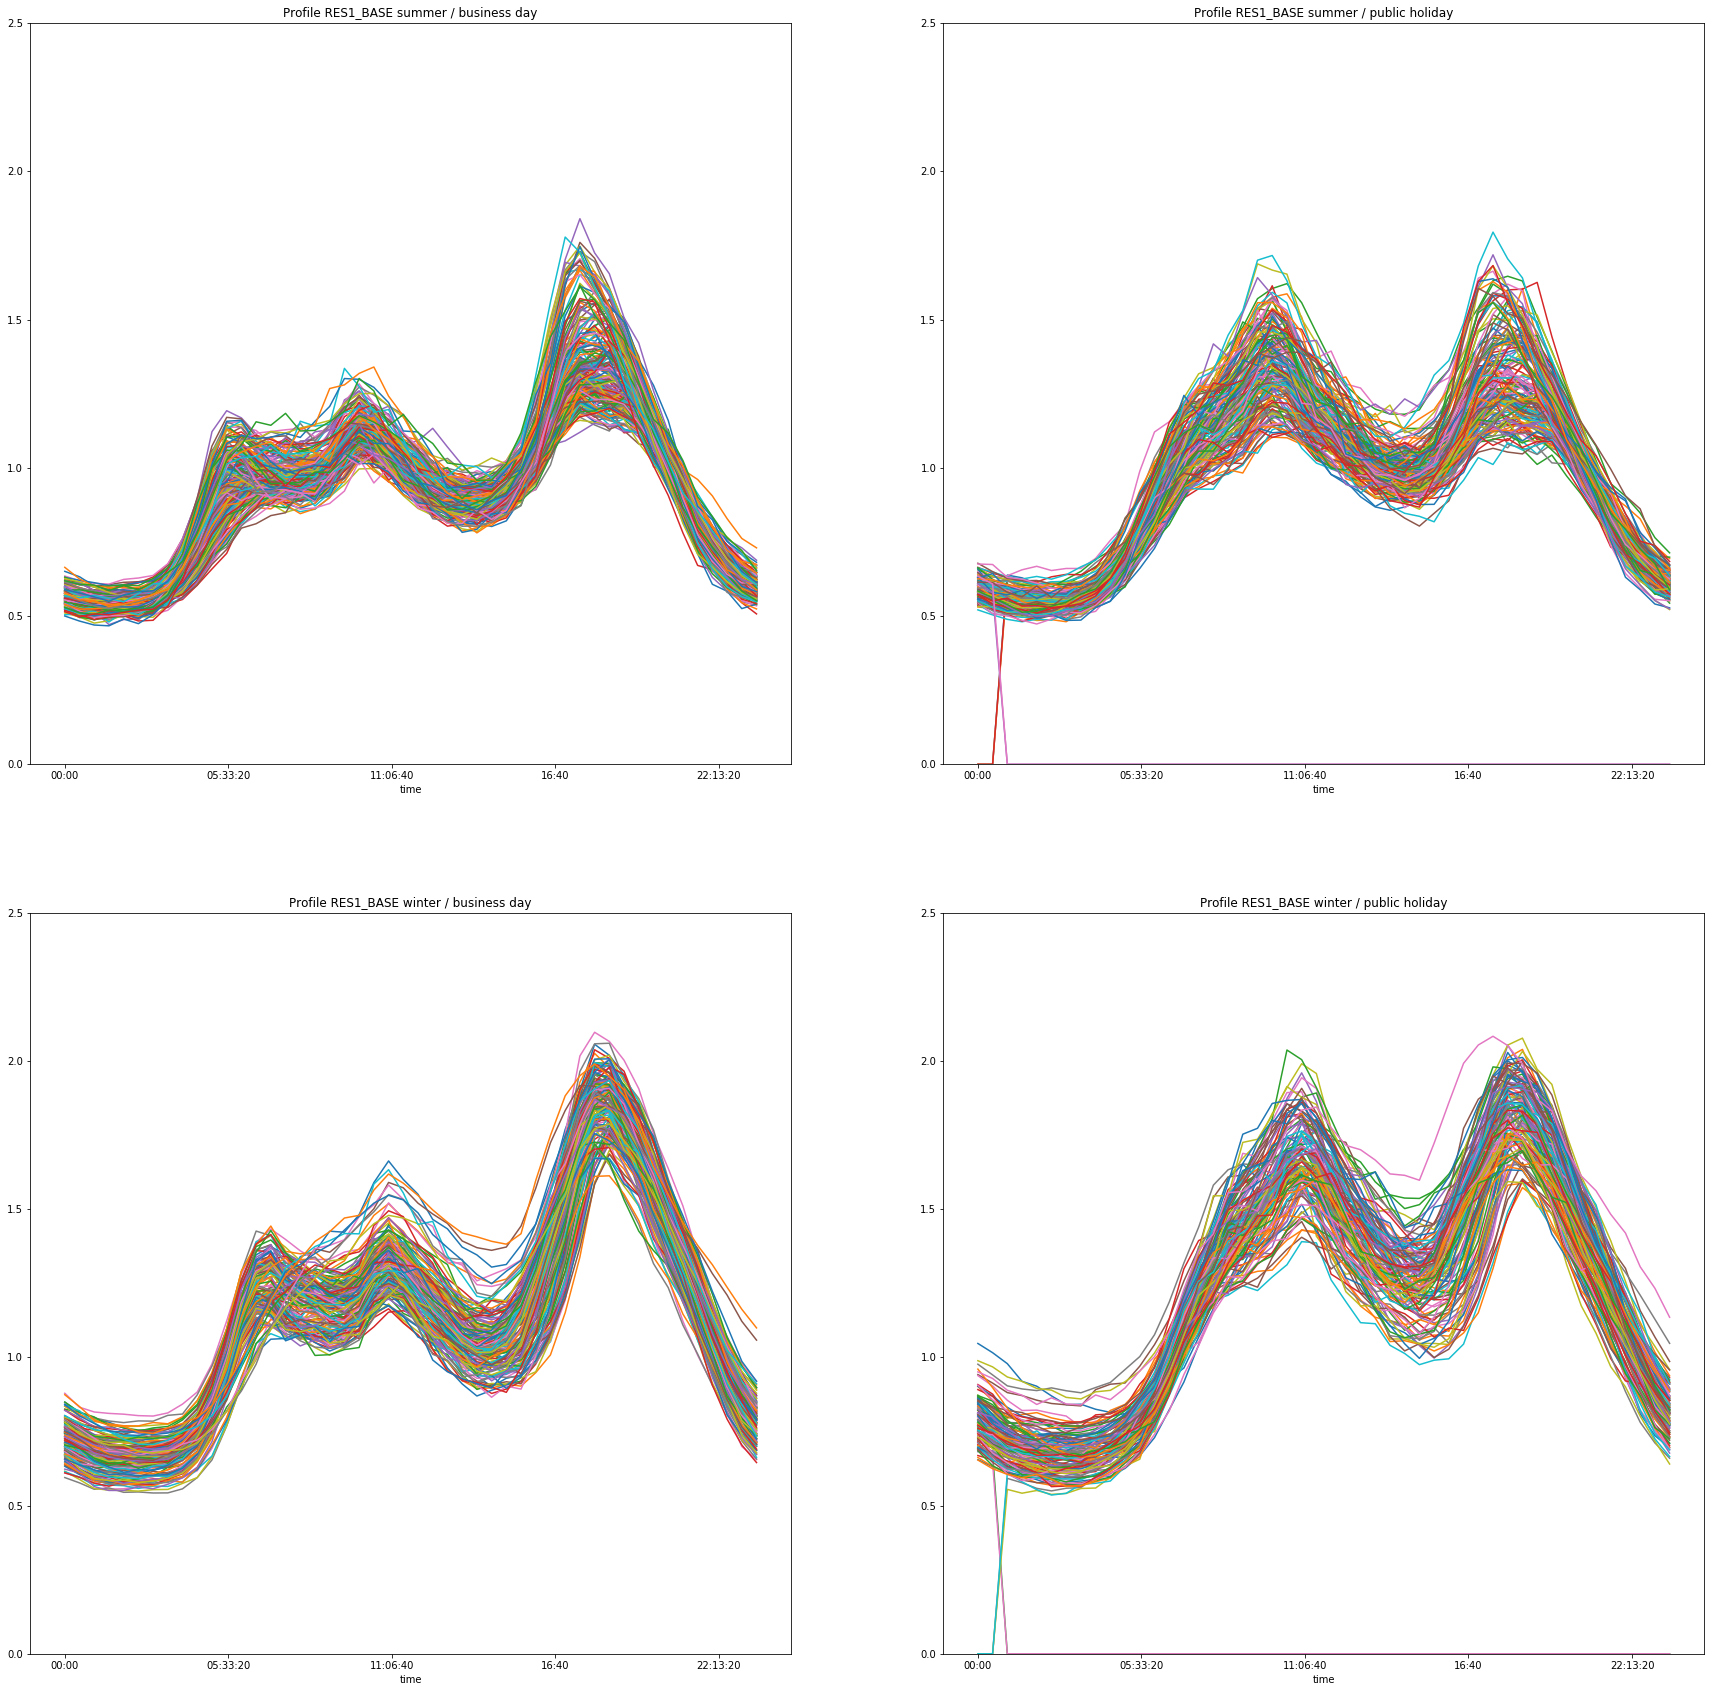

In [53]:
plt.figure(figsize=(30,30))
plt.subplot(221)
plt.ylim((0,2.5))
plt.plot(temp_summer_business_days.index,temp_summer_business_days)
plt.title('Profile RES1_BASE summer / business day')
print(plt.xticks())
plt.subplot(222)
plt.ylim((0,2.5))
plt.title('Profile RES1_BASE summer / public holiday')
plt.plot(temp_summer_public_holiday.index,temp_summer_public_holiday)
plt.subplot(223)
plt.ylim((0,2.5))
plt.title('Profile RES1_BASE winter / business day')
plt.plot(temp_winter_public_holiday.index,temp_winter_business_days)
plt.subplot(224)
plt.ylim((0,2.5))
plt.title('Profile RES1_BASE winter / public holiday')
plt.plot(temp_winter_public_holiday.index,temp_winter_public_holiday)
plt.show()

In [45]:
temp_winter_public_holiday.index

Index([00:00:00, 00:30:00, 01:00:00, 01:30:00, 02:00:00, 02:30:00, 03:00:00,
       03:30:00, 04:00:00, 04:30:00, 05:00:00, 05:30:00, 06:00:00, 06:30:00,
       07:00:00, 07:30:00, 08:00:00, 08:30:00, 09:00:00, 09:30:00, 10:00:00,
       10:30:00, 11:00:00, 11:30:00, 12:00:00, 12:30:00, 13:00:00, 13:30:00,
       14:00:00, 14:30:00, 15:00:00, 15:30:00, 16:00:00, 16:30:00, 17:00:00,
       17:30:00, 18:00:00, 18:30:00, 19:00:00, 19:30:00, 20:00:00, 20:30:00,
       21:00:00, 21:30:00, 22:00:00, 22:30:00, 23:00:00, 23:30:00],
      dtype='object', name='hour')

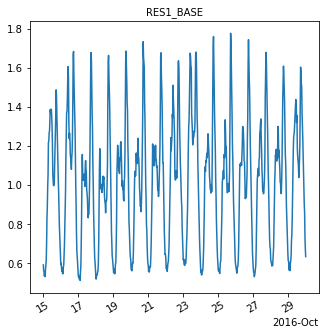

In [39]:
data_timeplot(data_slice_date(y_train,date(2016,10,15),date(2016,10,30),['RES1_BASE']))

In [38]:
data_slice_date(y_train,date(2017,10,15),date(2017,10,30),['RES1_BASE']).head()

Empty DataFrame
Columns: [RES1_BASE]
Index: []